# Problem 5

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import keras
import random
import numpy as np
import matplotlib.pyplot as plt


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras import layers

from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, UniversalPerturbation, SaliencyMapMethod
#from art.attacks import FastGradientMethod, BasicIterativeMethod, UniversalPerturbation, SaliencyMapMethod
#from art.classifiers import KerasClassifier
from art.estimators.classification import KerasClassifier

# Set the random seeds. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Defining some constants
NUM_CLASSES = 10
BATCH_SIZE = 64

## Setting up things

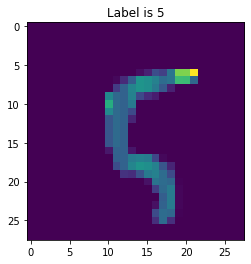

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# Plot an example image (after normalization) from the train set
plt.title('Label is {}'.format(y_train[100]))
plt.imshow(x_train[100])
plt.show()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

## Train CNN based model

### You need to complete the following.

In [4]:
# Define the CNN network architecture. 
cnn_based_model = Sequential()
cnn_based_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,28,28), data_format='channels_first'))

# Define the intermediate layers.

cnn_based_model.add(MaxPooling2D((2, 2)))
cnn_based_model.add(Flatten())
cnn_based_model.add(Dense(BATCH_SIZE, activation='relu'))
cnn_based_model.add(Dense(NUM_CLASSES, activation='softmax'))


In [5]:
# Compile the CNN model. 
# compile model
cnn_based_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

cnn_based_classifier = KerasClassifier(model=cnn_based_model, clip_values=(0,1))
cnn_based_classifier.fit(x_train, y_train, nb_epochs=5, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = cnn_based_model.predict(x_test,batch_size=BATCH_SIZE,verbose=0)

score = cnn_based_model.evaluate(x_test, y_test, verbose=0)

# Compute the accuracy on the test set.
cnn_score = score[1]

print('Test accuracy:', cnn_score)


Epoch 1/5
60000/60000 [==============================] - 58s 973us/step - loss: 0.2752 - accuracy: 0.9169
Epoch 2/5
60000/60000 [==============================] - 60s 997us/step - loss: 0.0957 - accuracy: 0.9718
Epoch 3/5
60000/60000 [==============================] - 58s 967us/step - loss: 0.0662 - accuracy: 0.9803
Epoch 4/5
60000/60000 [==============================] - 58s 969us/step - loss: 0.0514 - accuracy: 0.9851
Epoch 5/5
60000/60000 [==============================] - 58s 966us/step - loss: 0.0417 - accuracy: 0.9872
Test accuracy: 0.9822999835014343


## Train ANN based model (dense layers only)

### You need to complete the following.

In [6]:
# Define the ANN network architecture.
ann_based_model = Sequential()
ann_based_model.add(InputLayer(input_shape=(1,28,28)))

# Define the intermediate layers.

ann_based_model.add(Flatten())
ann_based_model.add(Dense(512, activation="relu"))
ann_based_model.add(Dense(256, activation="relu"))
ann_based_model.add(Dense(128, activation="relu"))
ann_based_model.add(Dense(64, activation="relu"))
ann_based_model.add(Dense(NUM_CLASSES, activation="softmax"))


In [7]:
# Compile the ANN model. 
ann_based_model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

In [8]:
ann_based_classifier = KerasClassifier(model=ann_based_model, clip_values=(0,1))
ann_based_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = ann_based_model.predict(x_test)

# Compute the accuracy on the test set.
score2 = ann_based_model.evaluate(x_test,y_test,verbose=0)
ann_score = score2[1]

print('Test accuracy:', ann_score)

Epoch 1/10
60000/60000 [==============================] - 10s 167us/step - loss: 0.2417 - acc: 0.9276
Epoch 2/10
60000/60000 [==============================] - 10s 158us/step - loss: 0.0935 - acc: 0.9711
Epoch 3/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.0642 - acc: 0.9804
Epoch 4/10
60000/60000 [==============================] - 10s 168us/step - loss: 0.0467 - acc: 0.9852
Epoch 5/10
60000/60000 [==============================] - 10s 172us/step - loss: 0.0353 - acc: 0.9886
Epoch 6/10
60000/60000 [==============================] - 10s 174us/step - loss: 0.0309 - acc: 0.9900
Epoch 7/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.0242 - acc: 0.9924
Epoch 8/10
60000/60000 [==============================] - 11s 179us/step - loss: 0.0201 - acc: 0.9934
Epoch 9/10
60000/60000 [==============================] - 11s 179us/step - loss: 0.0198 - acc: 0.9937
Epoch 10/10
60000/60000 [==============================] - 11s 179us/step - loss: 

## Compare the classification accuracy on the test data graphically

### You need to complete the following.

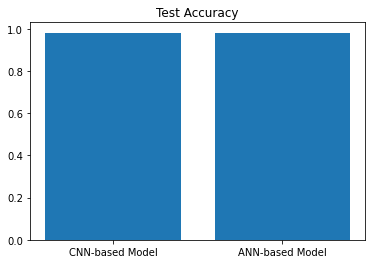

In [9]:
X = ['CNN-based Model','ANN-based Model']
Y = [cnn_score, ann_score]
plt.bar(X,Y)
plt.title('Test Accuracy')
plt.show()
plt.close()

## Part 2: Generate adversarial examples using four methods

### You need to complete the following.

In [10]:
def generate_adv_examples_FGSM(classifier, x):
    # This attack is known as the "Fast Gradient Sign Method".
    attacker = FastGradientMethod(estimator=classifier )
    attack = attacker.generate(x=x)
    return attack

def generate_adv_examples_BasicIterativeMethod(classifier, x):
    # The Basic Iterative Method is the iterative version of FGM and FGSM.
    attacker = BasicIterativeMethod(estimator=classifier)
    attack = attacker.generate(x=x)
    return attack

def generate_adv_examples_SaliencyMapMethod(classifier, x):
    # attack from the Jacobian-based Saliency Map Attack (Papernot et al. 2016).
    # Paper link: https://arxiv.org/abs/1511.07528
    attacker = SaliencyMapMethod(classifier=classifier)
    attack = attacker.generate(x=x)
    return attack

def generate_adv_examples_UniversalPerturbation(classifier, x):
    attacker = UniversalPerturbation(classifier=classifier)
    attack = attacker.generate(x=x)
    return attack

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/8 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

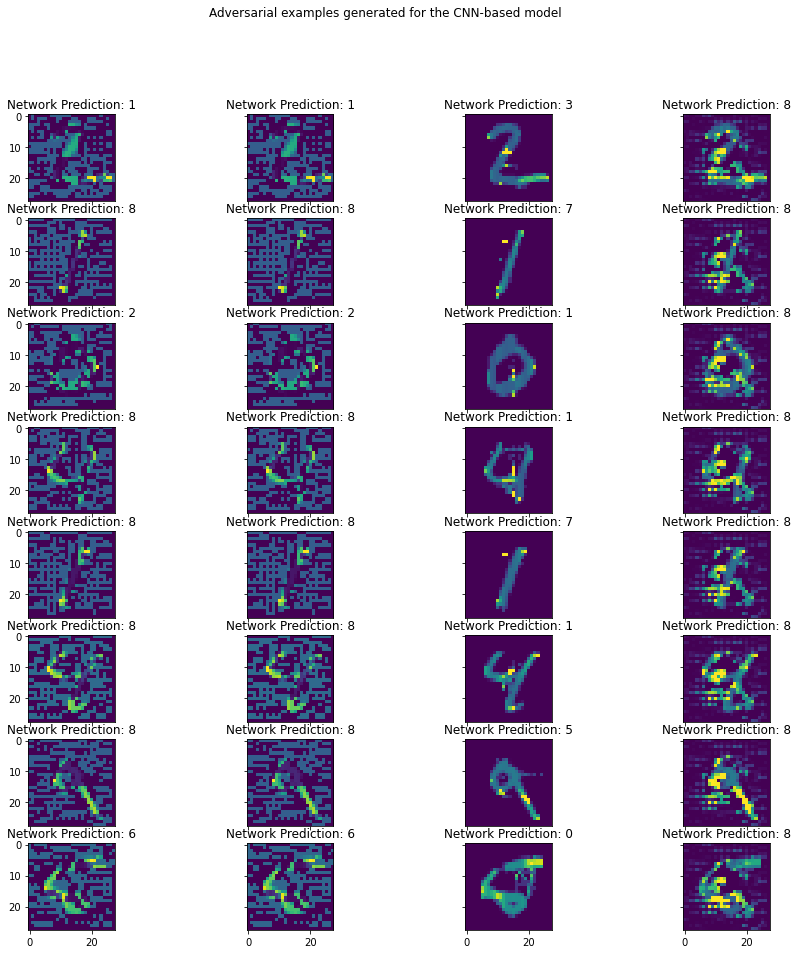

In [11]:
# Generate examples for CNN-based model
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier, x_test[1:9])
cnn_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(cnn_based_classifier,x_test[1:9])
cnn_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(cnn_based_classifier,x_test[1:9])
cnn_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(cnn_based_classifier,x_test[1:9])

# Generate plot
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the CNN-based model')
cnn_adv_examples = []
cnn_adv_examples.append(cnn_adv_examples_FGSM)
cnn_adv_examples.append(cnn_adv_examples_FGSM)
cnn_adv_examples.append(cnn_adv_examples_SaliencyMapMethod)
cnn_adv_examples.append(cnn_adv_examples_UniversalPerturbation)

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(cnn_adv_examples[j][i].squeeze())
        predictions = cnn_based_classifier.predict(np.expand_dims(cnn_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/8 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

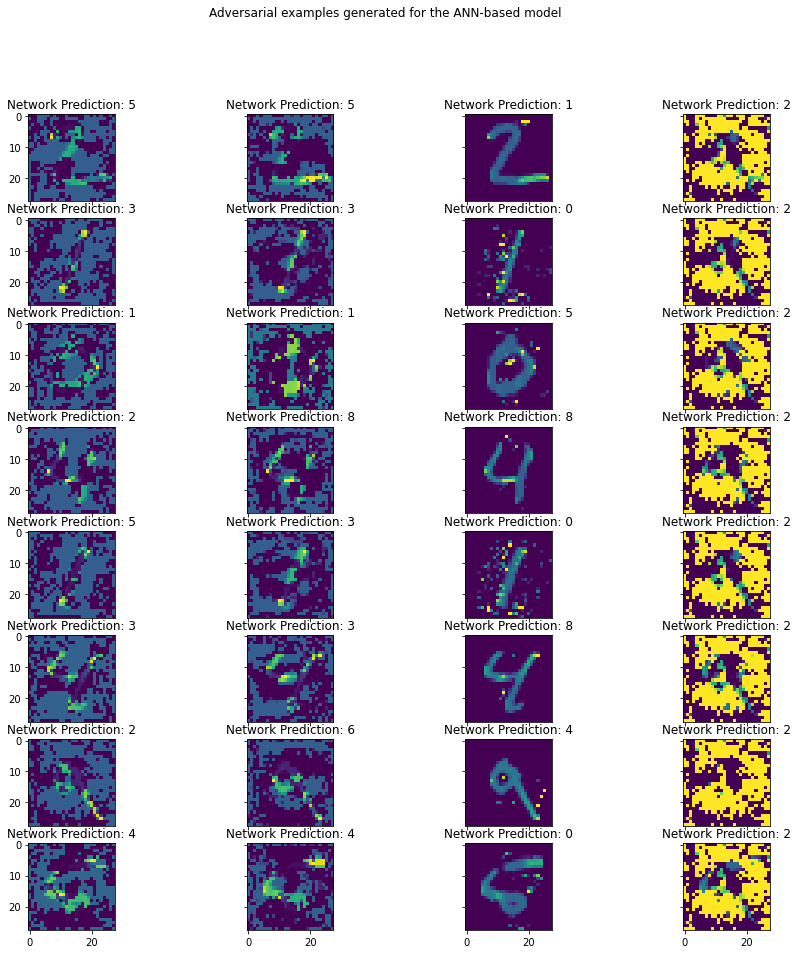

In [12]:
# Generate examples for ANN-based model
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier, x_test[1:9])
ann_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(ann_based_classifier,x_test[1:9])
ann_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(ann_based_classifier,x_test[1:9])
ann_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(ann_based_classifier,x_test[1:9])

# Generate plots
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the ANN-based model')
ann_adv_examples = []
ann_adv_examples.append(ann_adv_examples_FGSM)
ann_adv_examples.append(ann_adv_examples_BasicIterativeMethod)
ann_adv_examples.append(ann_adv_examples_SaliencyMapMethod)
ann_adv_examples.append(ann_adv_examples_UniversalPerturbation)

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(ann_adv_examples[j][i].squeeze())
        predictions = ann_based_classifier.predict(np.expand_dims(ann_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))
        

## Part 3: Create a new test set, based entirely on the adversarial images generated previously. Test your classifiers performance on this test set.

### You need to complete the following.

In [13]:
# We will be using the FGSM method in this part
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier, x_test)
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier, x_test)

In [14]:
# Evaluate ANN-based-classifier on the newly generated adversarial test set
predictions = ann_based_model.predict(ann_adv_examples_FGSM)
ann_based_score = ann_based_model.evaluate(ann_adv_examples_FGSM,y_test,verbose=0)[1]
print('ANN-based Model Score: {}'.format(ann_based_score))

ANN-based Model Score: 0.020999999716877937


In [15]:
# Evaluate CNN-based-classifier on the newly generated adversarial test set
predictions = cnn_based_model.predict(cnn_adv_examples_FGSM)
cnn_based_score = cnn_based_model.evaluate(cnn_adv_examples_FGSM,y_test,verbose=0)[1]
print('CNN-based Model Score: {}'.format(cnn_based_score))

CNN-based Model Score: 0.021199999377131462


## Create a new augmented test set (original test images + adversarial images)


### You need to complete the following.

In [18]:
# ANN-based-classifier
ann_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        ann_augmented_examples.append(ann_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        ann_augmented_examples.append(x_test[i])
        
#ann_augmented_examples = np.concatenate(ann_augmented_examples, axis=0)
ann_augmented_examples = np.array(ann_augmented_examples)

predictions = ann_based_model.predict(ann_augmented_examples)
ann_based_score_aug = ann_based_model.evaluate(ann_augmented_examples,y_test,verbose=0)[1]
print('ANN-based Model Score: {}'.format(ann_based_score_aug))

ANN-based Model Score: 0.49810001254081726


In [17]:
# CNN-based-classifier
cnn_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        cnn_augmented_examples.append(cnn_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        cnn_augmented_examples.append(x_test[i])

#cnn_augmented_examples = np.concatenate(cnn_augmented_examples, axis=0)
cnn_augmented_examples = np.array(cnn_augmented_examples)

predictions = cnn_based_model.predict(cnn_augmented_examples)
cnn_based_score_aug = cnn_based_model.evaluate(cnn_augmented_examples,y_test, verbose=0)[1]
print('CNN-based Model Score: {}'.format(cnn_based_score_aug))

CNN-based Model Score: 0.5019999742507935


## Make a single plot, wherein you compare the test accuracies of all the models, on the three types of test sets that you have

### You need to complete the following.

In [19]:
ann_models_score = [ann_score, ann_based_score_aug, ann_based_score]
cnn_models_score = [cnn_score, cnn_based_score_aug, cnn_based_score]

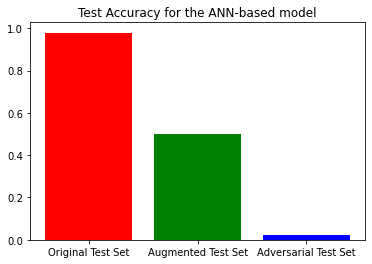

In [20]:
# Plot for the ANN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
plt.bar(X,ann_models_score, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the ANN-based model')
plt.show()
plt.close()

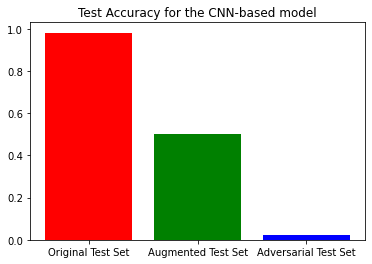

In [21]:
# Plot for the CNN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
plt.bar(X,cnn_models_score, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the CNN-based model')
plt.show()
plt.close()

In [ ]:
#6. 